# GAN Modell zur Generierung von synthetischen Daten


In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


## Data Preparation

In [2]:

# Daten laden
data = pd.read_csv('./../Data/preprocessed_df_v2.csv')  # Pfad zu Ihren Daten

# Extrahiere Participant und Test IDs
participant_ids = data['participant_id']
test_ids = data['test_id']

# Entferne die ID-Spalten aus den Daten, die skaliert werden sollen
data_for_scaling = data.drop(['participant_id', 'test_id'], axis=1)

# Auffüllen von NaN-Werten mit dem Mittelwert der jeweiligen Spalte
data_for_scaling = data_for_scaling.fillna(data_for_scaling.mean())

# Überprüfen auf NaN-Werte in den Daten
assert not np.any(np.isnan(data_for_scaling)), "Daten enthalten NaN-Werte"

# Daten skalieren
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data_for_scaling)

# Die skalierten Daten wieder mit den IDs zusammenführen
data_scaled = pd.DataFrame(data_scaled, columns=data_for_scaling.columns)
data_scaled['participant_id'] = participant_ids
data_scaled['test_id'] = test_ids

# die hinzugefügten IDs an den Anfang der Daten verschieben
cols = data_scaled.columns.tolist()
cols = cols[-2:] + cols[:-2]
data_scaled = data_scaled[cols]


print(data_scaled.head())

# GAN-Parameter
latent_dim = 100
data_dim = data_scaled.shape[1] - 2  # Nicht die ID-Spalten mitzählen

   participant_id  test_id  test_duration    mental  physical  temporal  \
0               1        1      -0.993814 -0.894737 -1.000000 -0.789474   
1               1        2      -0.995240 -0.052632 -0.473684 -0.578947   
2               1        3      -0.983375  1.000000 -0.894737  0.473684   
3               1        4      -0.992565  0.157895 -0.789474 -0.157895   
4               2        1      -0.991575 -0.684211 -0.894737 -0.684211   

   performance    effort  frustration    mean  ...  blinkrate  fixationrate  \
0    -0.473684 -0.578947    -0.894737 -0.7300  ...  -0.874455      0.072029   
1     0.052632 -0.789474    -0.578947 -0.2925  ...  -1.000000     -0.364152   
2     0.684211  0.789474    -0.684211  0.4575  ...  -0.586037     -0.289947   
3     0.052632 -0.684211    -0.578947 -0.2100  ...  -0.889323      0.044196   
4    -0.789474 -0.684211    -0.789474 -0.7100  ...  -0.898826     -0.479368   

   blinkrate_rel  blinkrate_rel_pct  fixationrate_rel  fixationrate_rel_pc

## GAN Definition

In [3]:
# Generator-Modell
def build_generator(latent_dim, data_dim, num_participants, num_tests):
    # Eingabe für die IDs
    participant_input = tf.keras.layers.Input(shape=(1,))
    test_input = tf.keras.layers.Input(shape=(1,))
    latent_input = tf.keras.layers.Input(shape=(latent_dim,))
    
    # Embedding für kategorielle Eingaben
    participant_embedding = tf.keras.layers.Embedding(num_participants, 5)(participant_input)
    test_embedding = tf.keras.layers.Embedding(num_tests, 5)(test_input)
    
    # flatten
    participant_flat = tf.keras.layers.Flatten()(participant_embedding)
    test_flat = tf.keras.layers.Flatten()(test_embedding)
    
    # Kombinieren der Eingaben
    combined_input = tf.keras.layers.concatenate([latent_input, participant_flat, test_flat])
    
    # Weiter mit dem vorherigen Modell
    x = tf.keras.layers.Dense(128)(combined_input)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)
    x = tf.keras.layers.Dense(512)(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)
    output = tf.keras.layers.Dense(data_dim, activation='tanh')(x)
    
    model = tf.keras.Model(inputs=[latent_input, participant_input, test_input], outputs=output)
    return model

# Diskriminator-Modell
def build_discriminator(data_dim, num_participants, num_tests):
    # Eingabe für die Daten
    data_input = tf.keras.layers.Input(shape=(data_dim,))
    participant_input = tf.keras.layers.Input(shape=(1,))
    test_input = tf.keras.layers.Input(shape=(1,))

    # Embedding für kategoriale Eingaben
    participant_embedding = tf.keras.layers.Embedding(num_participants, 5)(participant_input)
    test_embedding = tf.keras.layers.Embedding(num_tests, 5)(test_input)
    
    # Flachlegen der Embeddings
    participant_flat = tf.keras.layers.Flatten()(participant_embedding)
    test_flat = tf.keras.layers.Flatten()(test_embedding)
    
    # Kombinieren der Eingaben
    combined_input = tf.keras.layers.concatenate([data_input, participant_flat, test_flat])
    
    # Weiter mit dem vorherigen Modell
    x = tf.keras.layers.Dense(512)(combined_input)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=[data_input, participant_input, test_input], outputs=output)
    return model

# GAN-Modell
def build_gan(generator, discriminator):
    # Stelle sicher, dass der Diskriminator beim Trainieren des GANs nicht aktualisiert wird
    discriminator.trainable = False
    
    # Eingaben für das GAN-Modell
    latent_input = tf.keras.layers.Input(shape=(generator.input_shape[0][1],))
    participant_input = tf.keras.layers.Input(shape=(1,))
    test_input = tf.keras.layers.Input(shape=(1,))
    
    # Generator und Diskriminator verbinden
    generated_data = generator([latent_input, participant_input, test_input])
    gan_output = discriminator([generated_data, participant_input, test_input])
    
    # GAN-Modell erstellen
    model = tf.keras.Model(inputs=[latent_input, participant_input, test_input], outputs=gan_output)
    return model

In [4]:
# Hyperparameter
learning_rate_discriminator = 0.00005
learning_rate_generator = 0.0001

num_participants = data_scaled['participant_id'].nunique()
num_tests = 4

# Modelle mit konditionierten Inputs erstellen
generator = build_generator(latent_dim, data_dim, num_participants, num_tests)
discriminator = build_discriminator(data_dim, num_participants, num_tests)

# Kompilieren des Diskriminators
discriminator.compile(optimizer=Adam(learning_rate_discriminator, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Diskriminator trainierbar auf False setzen für GAN
discriminator.trainable = False

# GAN-Modell erstellen
gan = build_gan(generator, discriminator)
gan.compile(optimizer=Adam(learning_rate_generator, 0.5), loss='binary_crossentropy')

# Vorbereiten der Eingaben für das Training
participant_ids = data_scaled['participant_id'].values
test_ids = data_scaled['test_id'].values

# Die tatsächlichen skalierten Trainingsdaten ohne die ID-Spalten
real = data_scaled.drop(['participant_id', 'test_id'], axis=1).values
real_labels = np.ones((real.shape[0], 1))
fake_labels = np.zeros((real.shape[0], 1))

2024-06-16 17:00:35.346553: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-06-16 17:00:35.346571: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-06-16 17:00:35.346576: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-06-16 17:00:35.346591: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-16 17:00:35.346600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Training

In [5]:
# GAN-Training
epochs = 1000
batch_size = 32

d_losses = []
g_losses = []

for epoch in range(epochs):
    idx = np.random.randint(0, real.shape[0], batch_size)
    real_samples = real[idx]
    real_participant_ids = participant_ids[idx]
    real_test_ids = test_ids[idx]
    
    # Umwandlung in Tensoren mit festgelegter Form
    real_participant_ids_tensor = tf.constant(real_participant_ids, dtype=tf.int32, shape=(batch_size, 1))
    real_test_ids_tensor = tf.constant(real_test_ids, dtype=tf.int32, shape=(batch_size, 1))
    
    # Zufälliges Rauschen und Fake-Daten generieren
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_samples = generator.predict([noise, real_participant_ids, real_test_ids])
    
    # Diskriminator trainieren
    d_loss_real = discriminator.train_on_batch([real_samples, real_participant_ids, real_test_ids], real_labels[:batch_size])
    d_loss_fake = discriminator.train_on_batch([fake_samples, real_participant_ids, real_test_ids], fake_labels[:batch_size])
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # GAN trainieren (das Ziel ist, den Diskriminator zu täuschen)
    g_loss = gan.train_on_batch([noise, real_participant_ids, real_test_ids], real_labels[:batch_size])
    
    # Verluste speichern
    d_losses.append(d_loss[0])
    g_losses.append(g_loss)
    
    # Fortschritt ausgeben
    if (epoch + 1) % 1 == 0:  # Ersetzt 1000 durch 1 für das Debugging
        print(f"{epoch + 1} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")


print("Training abgeschlossen!")
print(f"{epochs} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


2024-06-16 17:00:48.553983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/hennerbendig/anaconda3/envs/tf_311/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1 [D loss: 0.6919571757316589, acc.: 51.5625%] [G loss: [array(0.6958989, dtype=float32), array(0.6958989, dtype=float32), array(0.4375, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
2 [D loss: 0.6918249130249023, acc.: 48.828125%] [G loss: [array(0.6940359, dtype=float32), array(0.6940359, dtype=float32), array(0.4453125, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3 [D loss: 0.6933890581130981, acc.: 45.520833134651184%] [G loss: [array(0.6951658, dtype=float32), array(0.6951658, dtype=float32), array(0.41666666, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4 [D loss: 0.6949055194854736, acc.: 42.66183078289032%] [G loss: [array(0.6960409, dtype=float32), array(0.6960409, dtype=float32), array(0.40234375, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
5 [D loss: 0.6965758800506592, acc.: 39.73958492279053%] [G loss: [array(0.6979226, dtype=float32), array(0.6979226, dtype=float32), array(0.378125, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/ste

KeyboardInterrupt: 

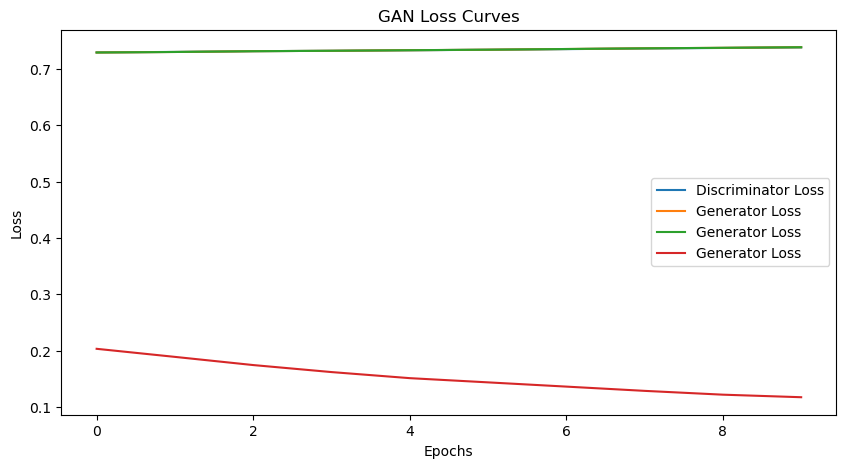

In [10]:
# Verlustkurven plotten
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Loss Curves")
plt.show()

## Daten generieren

In [20]:
# Anzahl der zusätzlichen Teilnehmer, die generiert werden sollen
num_additional_participants = 250  # 250 Participants, jeder führt 4 Tests durch, ergibt 1000 Punkte
num_tests_per_participant = 4

# Höchste vorhandene Participant ID ermitteln
max_participant_id = data['participant_id'].max()

# Neue Participant IDs generieren
new_participant_ids = np.arange(max_participant_id + 1, max_participant_id + 1 + num_additional_participants)

# Test IDs für jeden neuen Teilnehmer festlegen (1, 2, 3, 4)
new_test_ids = np.tile(np.arange(1, num_tests_per_participant + 1), num_additional_participants)

# Erweiterung der Participant IDs, um die Test IDs zu matchen
extended_participant_ids = np.repeat(new_participant_ids, num_tests_per_participant)

# Zufälliges Rauschen generieren
noise = np.random.normal(0, 1, (num_additional_participants * num_tests_per_participant, latent_dim))

# IDs in Tensoren umwandeln und sicherstellen, dass die Form definiert ist
participant_ids_tensor = tf.constant(extended_participant_ids.reshape(-1, 1), dtype=tf.int32)
test_ids_tensor = tf.constant(new_test_ids.reshape(-1, 1), dtype=tf.int32)

# Fake-Daten generieren
synthetic_data_scaled = generator.predict([noise, participant_ids_tensor, test_ids_tensor])

# Die generierten Daten zurückskalieren auf den ursprünglichen Wertebereich
synthetic_data = scaler.inverse_transform(synthetic_data_scaled)

# IDs zu den generierten Daten hinzufügen
synthetic_data_with_ids = np.hstack((extended_participant_ids.reshape(-1, 1), new_test_ids.reshape(-1, 1), synthetic_data))

# Die generierten Daten mit den Originaldaten kombinieren
augmented_data = np.vstack((data.values, synthetic_data_with_ids))

# In ein TensorFlow-Dataset umwandeln
dataset = tf.data.Dataset.from_tensor_slices(augmented_data)

print("Original Data Shape:", data.shape)
print("Synthetic Data Shape:", synthetic_data_with_ids.shape)
print("Augmented Data Shape:", augmented_data.shape)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Original Data Shape: (188, 22)
Synthetic Data Shape: (1000, 22)
Augmented Data Shape: (1188, 22)


In [23]:
# Ausgewählte Datenpunkte plotten
synthetic_data_with_ids = pd.DataFrame(synthetic_data_with_ids, columns=data.columns)
print("Synthetic Data")
print(synthetic_data_with_ids[:25])

# Speichern der generierten Daten
synthetic_data_with_ids.to_csv('./../Data/synthetic_data.csv', index=False)  

print("Synthetic Data saved successfully!")

Synthetic Data
    participant_id  test_id  test_duration     mental   physical   temporal  \
0             48.0      1.0    1970.496826  40.866222  83.737968  25.457342   
1             48.0      2.0    1711.414917  37.799812  83.510956  41.472267   
2             48.0      3.0    1384.516479  42.373051  74.030121  34.044357   
3             48.0      4.0    3138.704346  56.178856  63.045761  36.343693   
4             49.0      1.0    1975.776001  47.283787  71.373482  50.820206   
5             49.0      2.0    2313.618408  37.062622  80.452797  37.445168   
6             49.0      3.0    1800.640259  65.775749  82.963997  21.701382   
7             49.0      4.0    1602.068848  72.073486  77.809669  31.533545   
8             50.0      1.0    2272.337891  50.927929  66.048485  43.956764   
9             50.0      2.0    3558.970459  54.386864  76.891289  42.988350   
10            50.0      3.0    2444.677734  56.869267  79.089203  25.072449   
11            50.0      4.0    1688.0

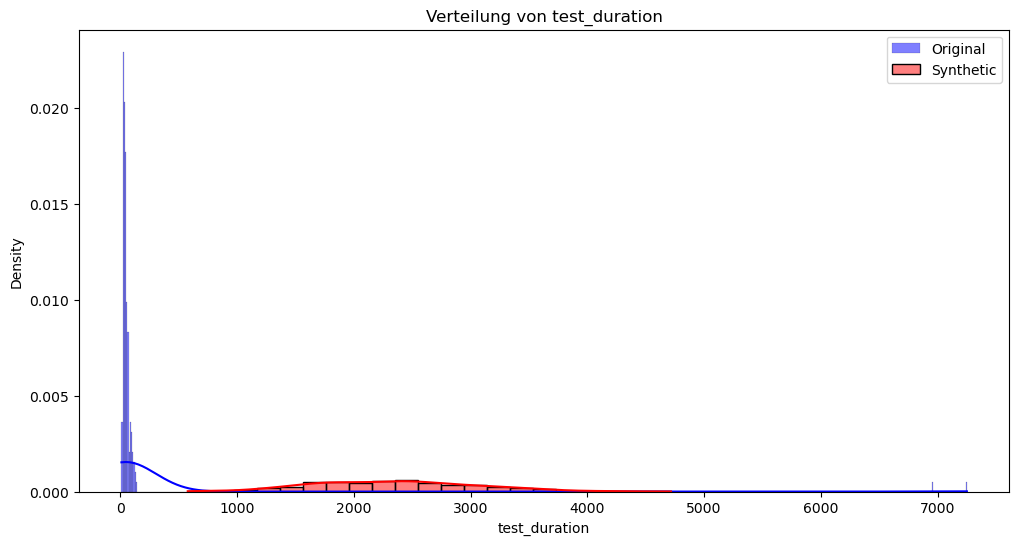

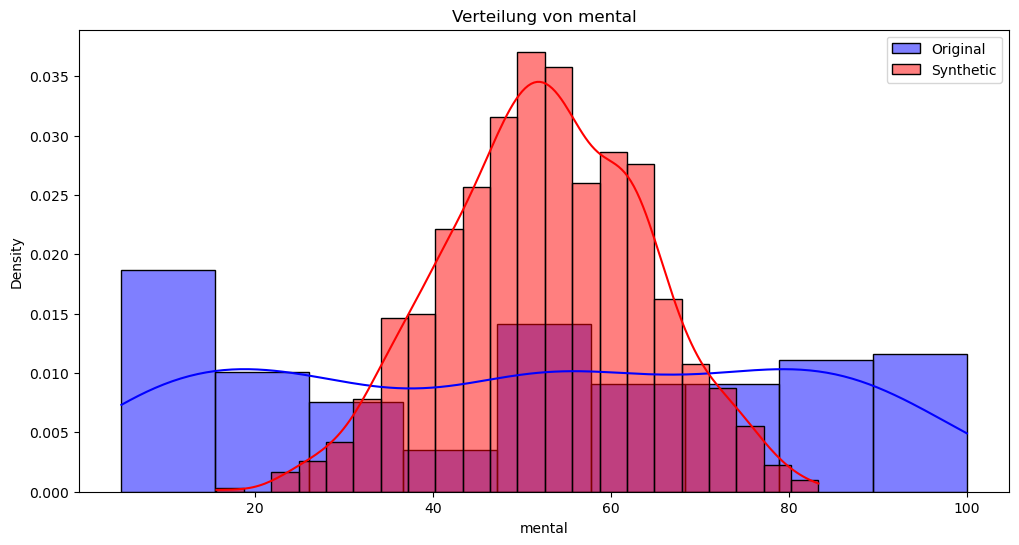

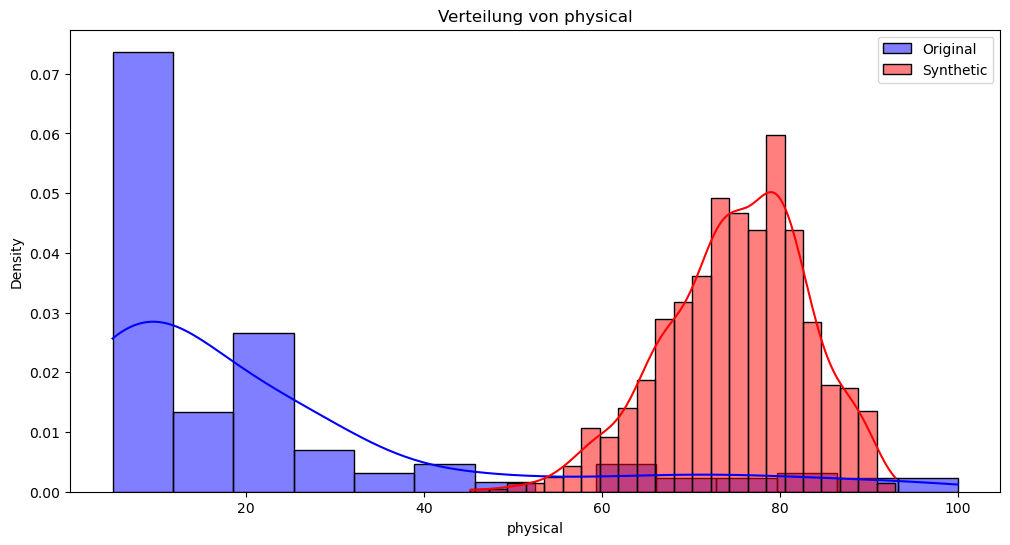

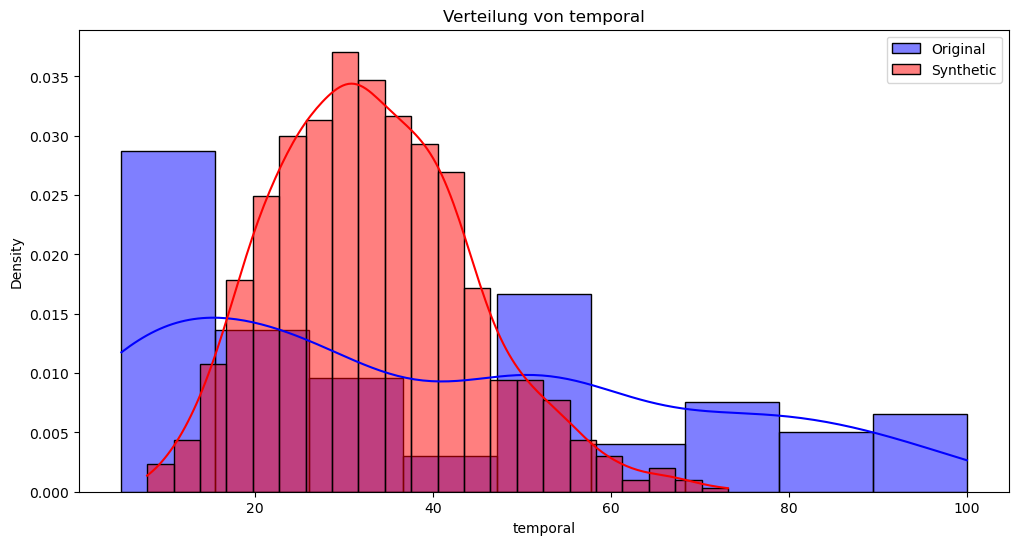

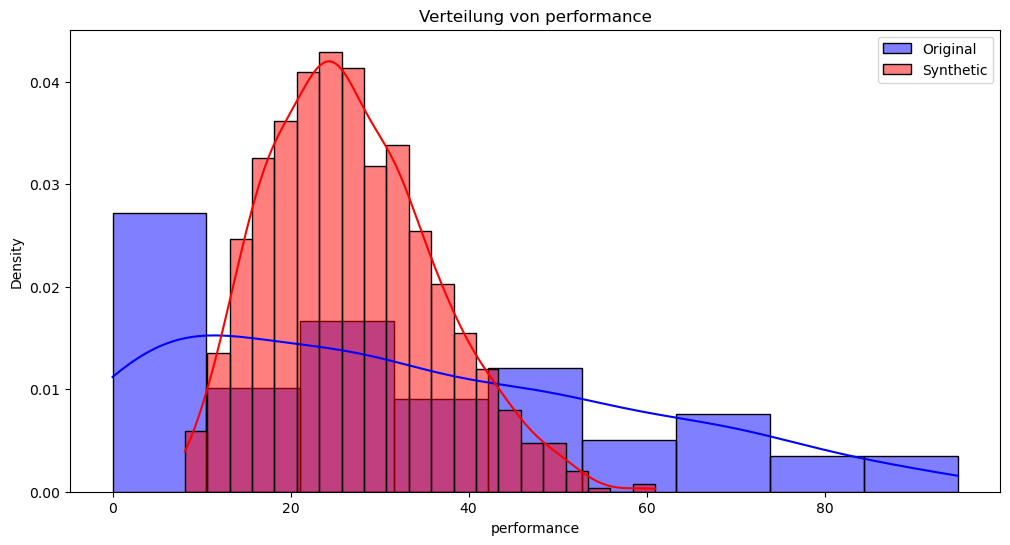

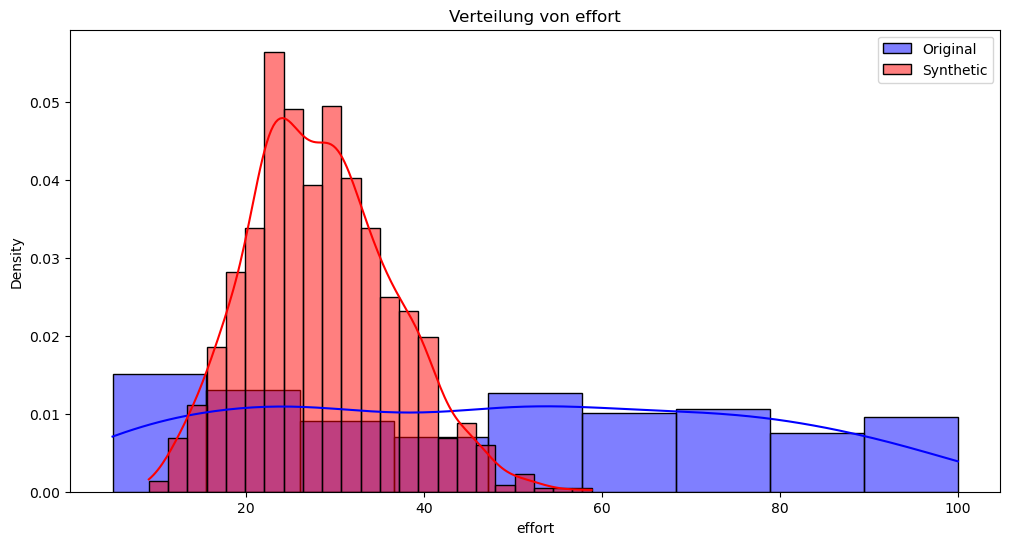

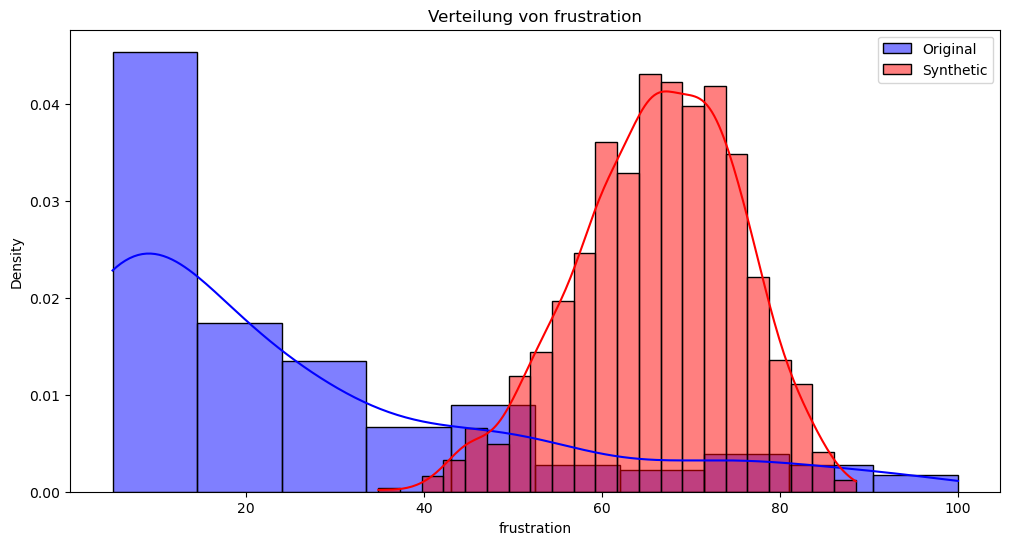

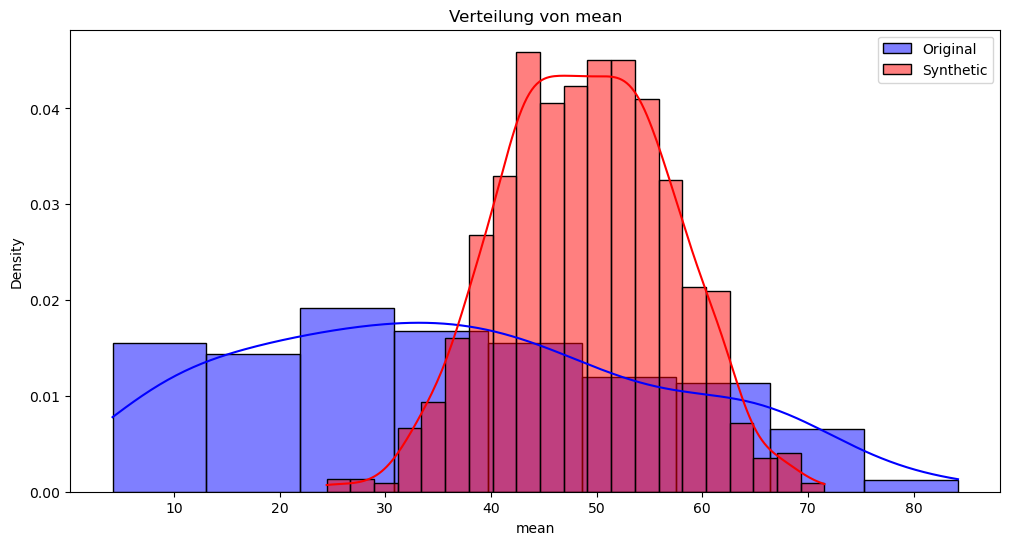

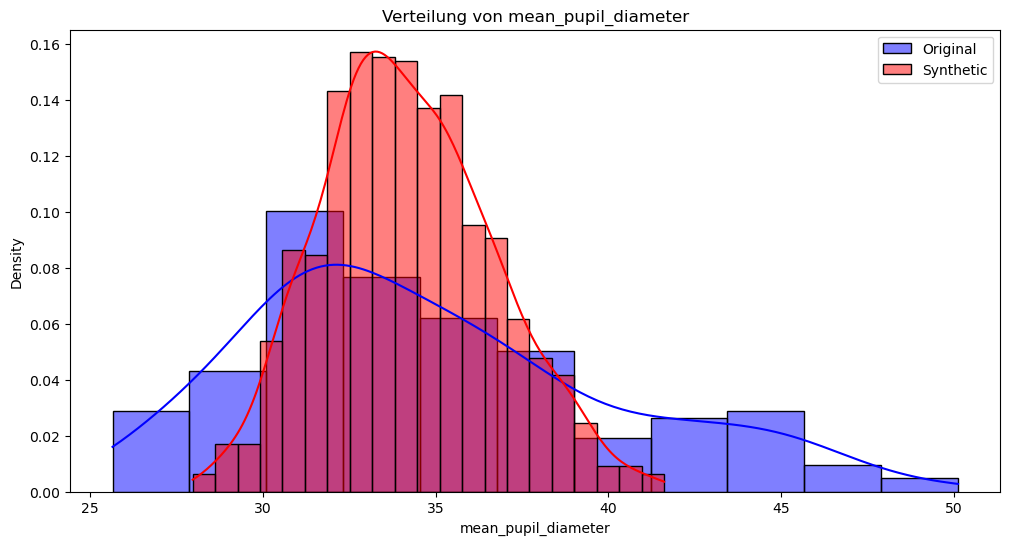

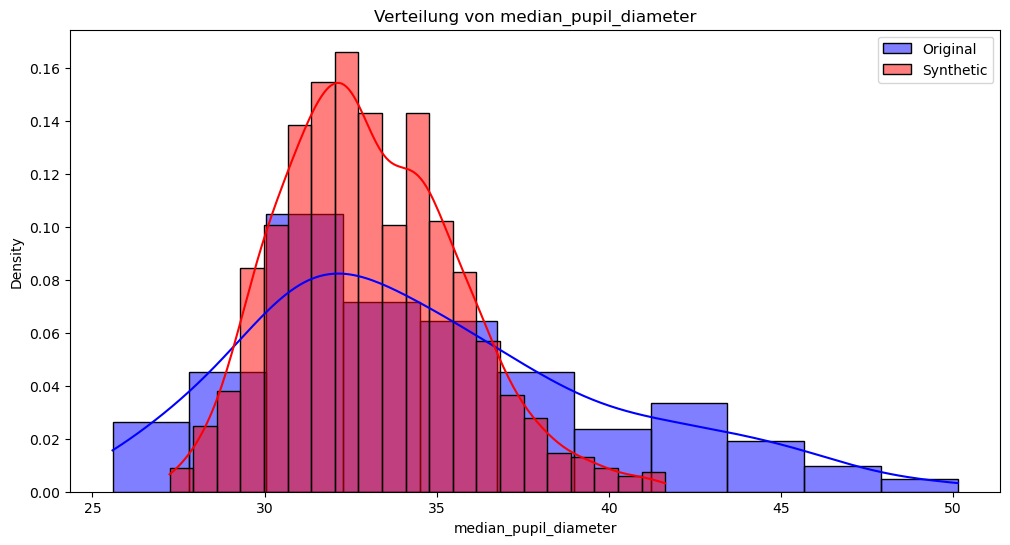

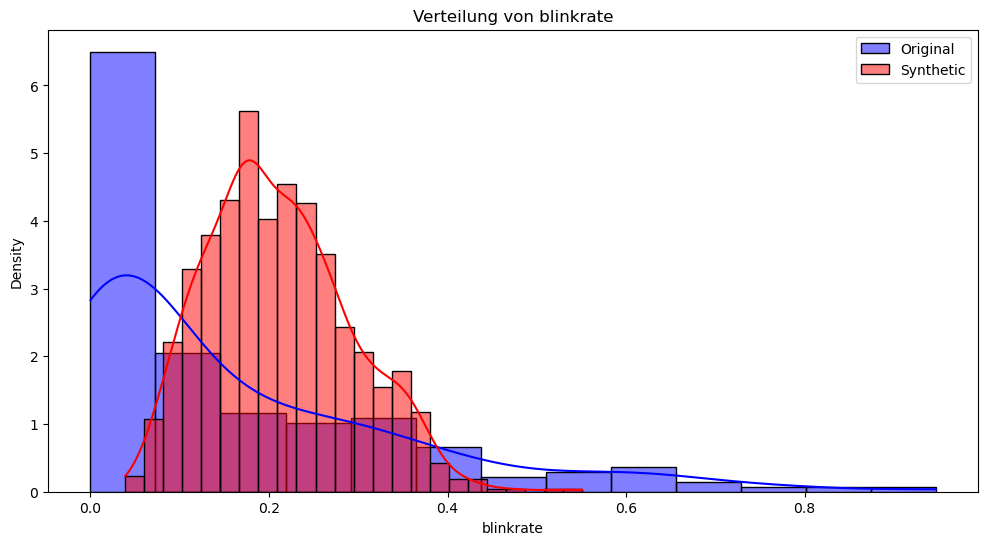

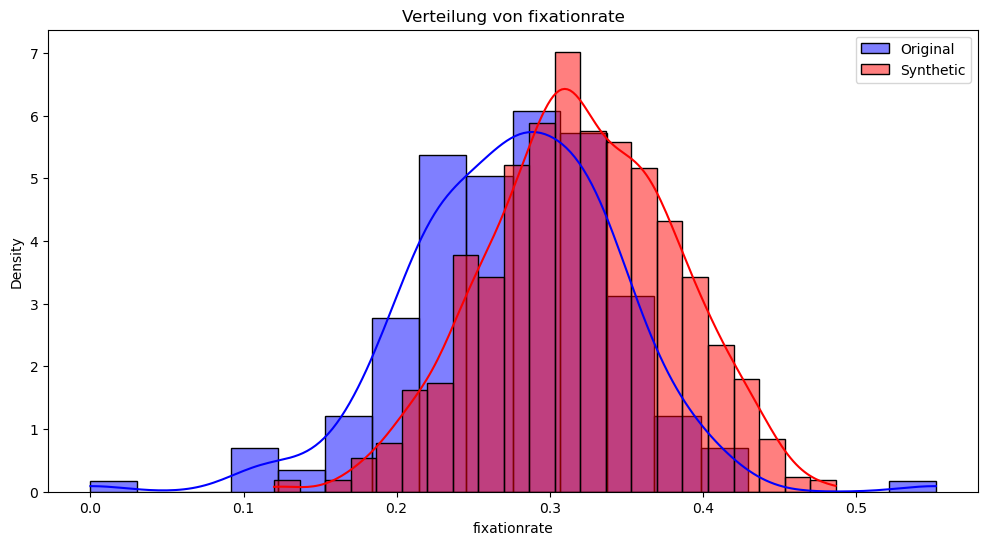

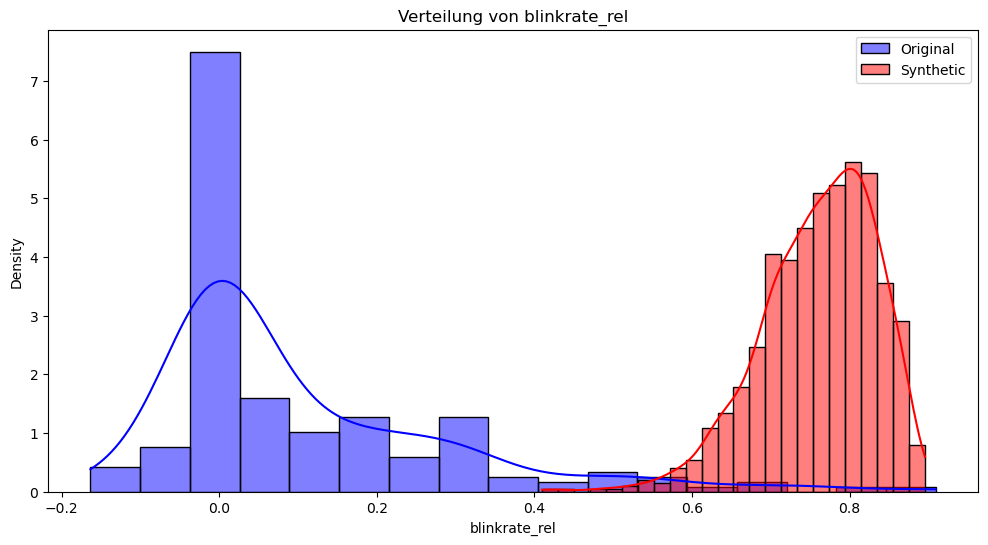

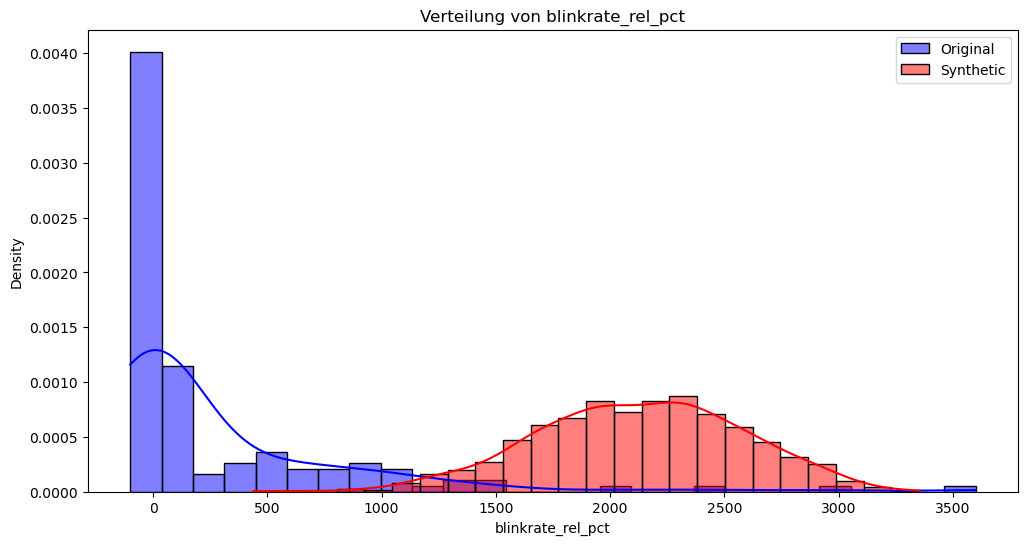

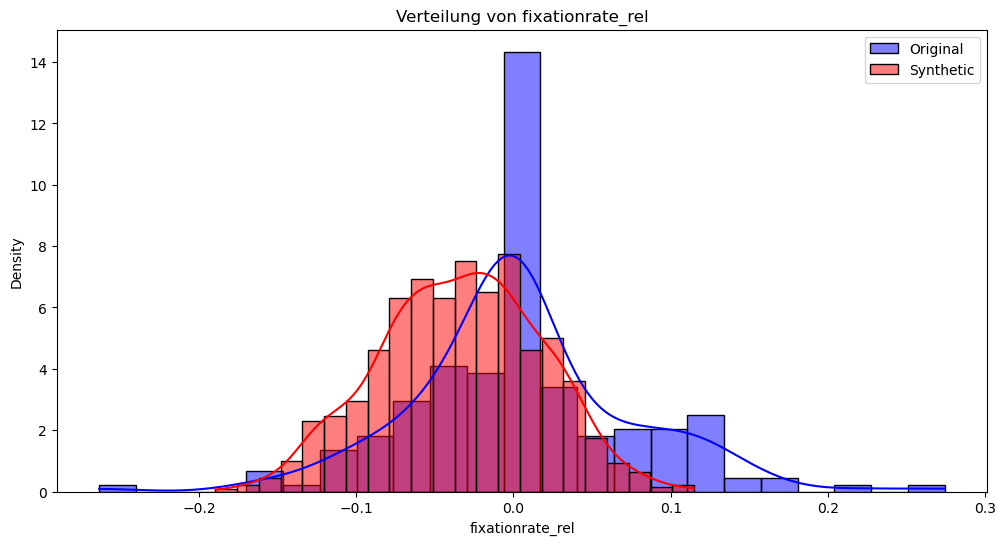

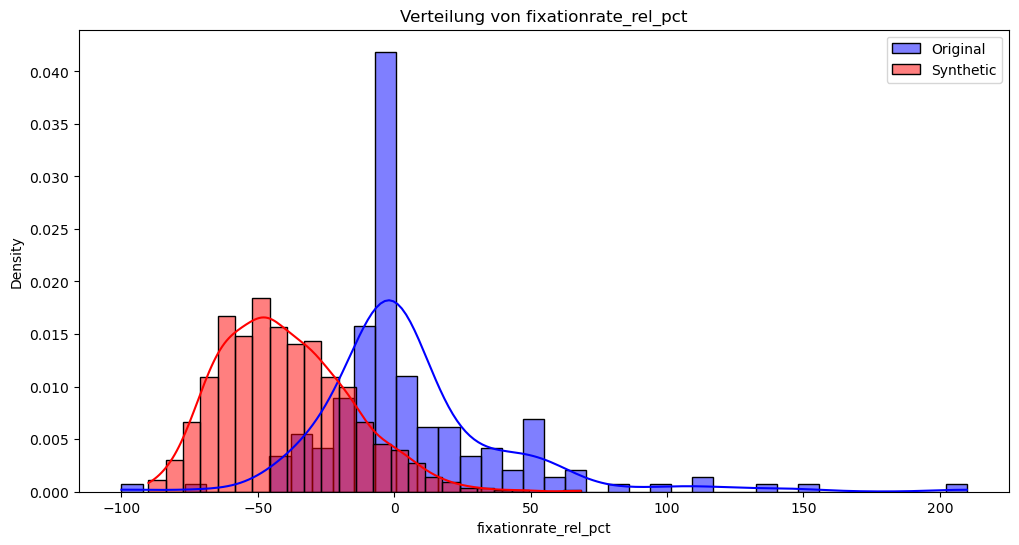

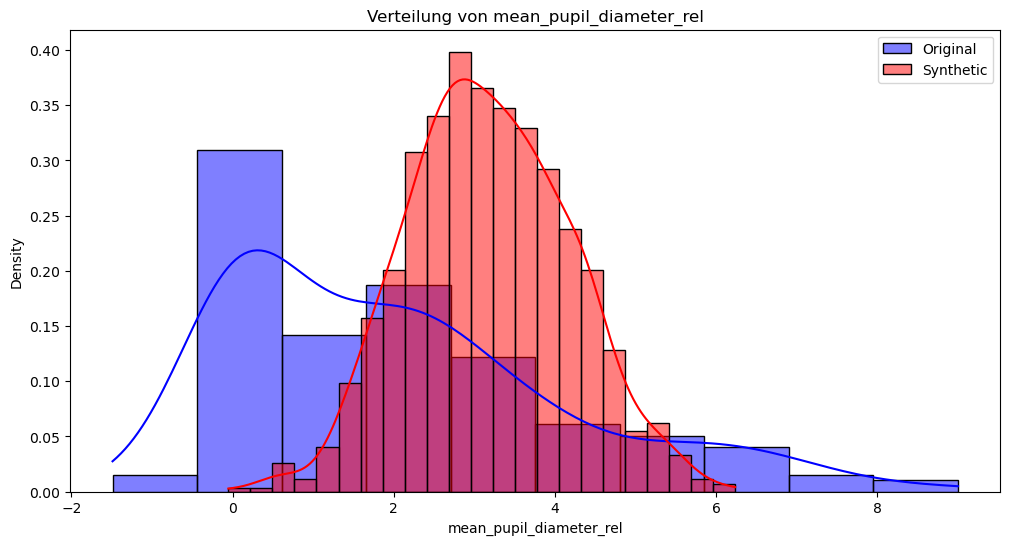

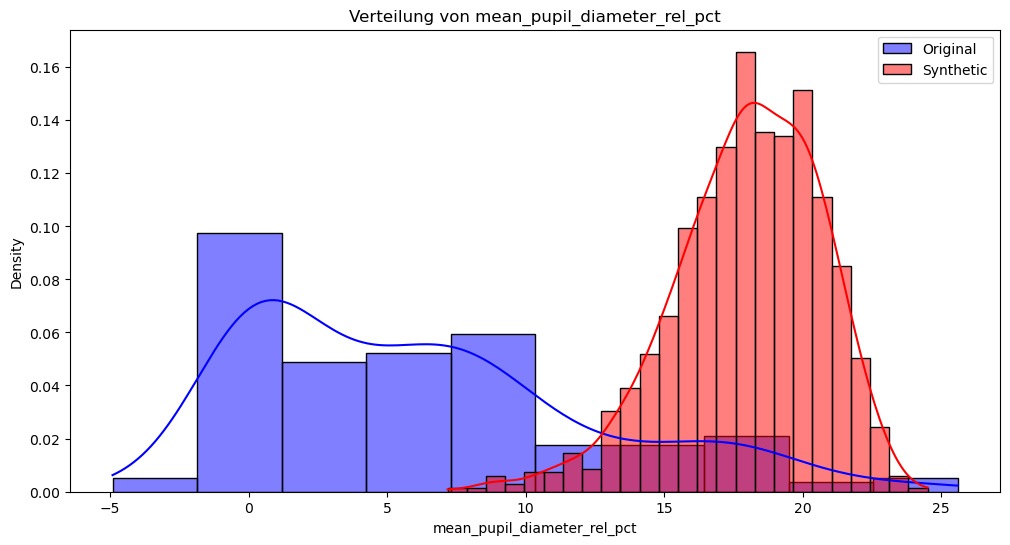

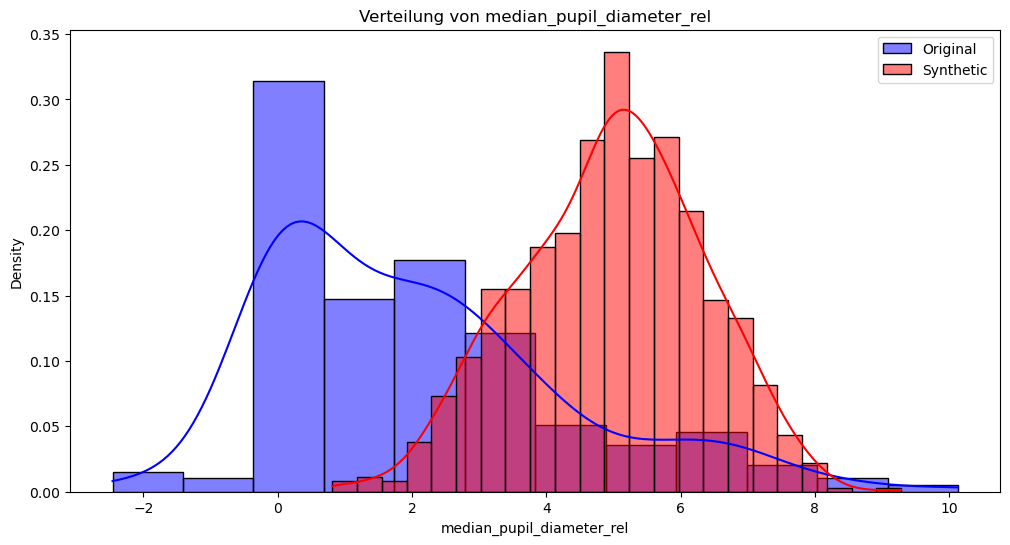

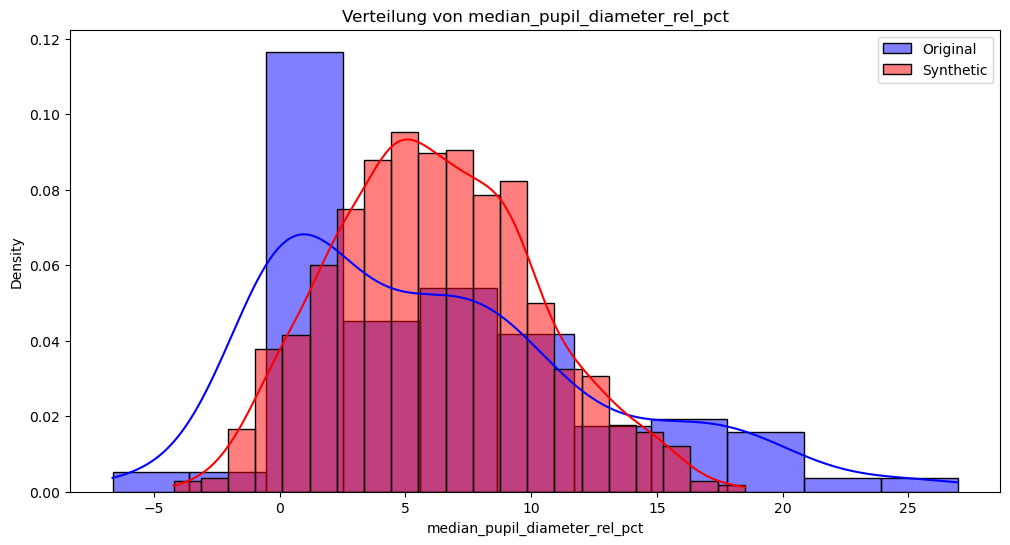

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Konvertiere die augmented_data in ein DataFrame
augmented_df = pd.DataFrame(augmented_data, columns=data.columns)

# Getrennte DataFrames für Original- und generierte Daten
original_df = data.copy()
synthetic_df = augmented_df.iloc[len(data):].copy()

# Histogramme und Dichtekurven für jede Spalte
for column in data.columns:
    if column not in ['participant_id', 'test_id']:  # IDs auslassen
        plt.figure(figsize=(12, 6))
        sns.histplot(original_df[column], kde=True, color='blue', label='Original', stat='density')
        sns.histplot(synthetic_df[column], kde=True, color='red', label='Synthetic', stat='density')
        plt.title(f'Verteilung von {column}')
        plt.legend()
        plt.show()

In [31]:
from scipy.stats import ks_2samp

for column in data.columns:
    if column not in ['participant_id', 'test_id']:  # IDs auslassen
        stat, p_value = ks_2samp(original_df[column], synthetic_df[column])
        print(f'Kolmogorov-Smirnov-Test für {column}:')
        print(f'Statistik = {stat}, p-Wert = {p_value}')
        if p_value > 0.05:
            print("Die Verteilungen sind ähnlich (Nullhypothese nicht verworfen).")
        else:
            print("Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).")
        print()

Kolmogorov-Smirnov-Test für test_duration:
Statistik = 0.9893617021276596, p-Wert = 5.839086879060571e-208
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).

Kolmogorov-Smirnov-Test für mental:
Statistik = 0.32374468085106384, p-Wert = 3.1720124753576545e-15
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).

Kolmogorov-Smirnov-Test für physical:
Statistik = 0.8809787234042553, p-Wert = 1.7950232104753655e-135
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).

Kolmogorov-Smirnov-Test für temporal:
Statistik = 0.3422127659574468, p-Wert = 5.363157787858045e-17
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).

Kolmogorov-Smirnov-Test für performance:
Statistik = 0.2961063829787234, p-Wert = 9.033663051760696e-13
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).

Kolmogorov-Smirnov-Test für effort:
Statistik = 0.5391489361702128, p-Wert = 4.181497246598481

In [36]:

import scipy.stats as stats
from scipy.stats import ttest_ind, kruskal

# Funktion zur Durchführung der Tests
def normality_test(data, column):
    stat, p_value = stats.shapiro(data[column])
    return p_value > 0.05  # Normal verteilt, wenn p-Wert > 0.05

def compare_means(original, synthetic, column):
    is_normal_original = normality_test(original, column)
    is_normal_synthetic = normality_test(synthetic, column)
    
    print(f'Normalitätstest für {column}:')
    print(f'Originaldaten: {"Normalverteilt" if is_normal_original else "Nicht-normalverteilt"}')
    print(f'Generierte Daten: {"Normalverteilt" if is_normal_synthetic else "Nicht-normalverteilt"}')
    
    if is_normal_original and is_normal_synthetic:
        # t-Test anwenden
        stat, p_value = ttest_ind(original[column], synthetic[column], equal_var=False)
        print(f't-Test für {column}:')
    else:
        # Kruskal-Wallis H-Test anwenden
        stat, p_value = kruskal(original[column], synthetic[column])
        print(f'Kruskal-Wallis H-Test für {column}:')
    
    print(f'Statistik = {stat}, p-Wert = {p_value}')
    if p_value > 0.05:
        print("Die Verteilungen sind ähnlich (Nullhypothese nicht verworfen).")
    else:
        print("Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).")
    print()



# Vergleiche die Verteilungen für jede Spalte
for column in data.columns:
    if column not in ['participant_id', 'test_id']:  # IDs auslassen
        compare_means(original_df, synthetic_df, column)

Normalitätstest für test_duration:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für test_duration:
Statistik = 454.37790318096904, p-Wert = 8.042162371225988e-101
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).

Normalitätstest für mental:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Normalverteilt
Kruskal-Wallis H-Test für mental:
Statistik = 0.5881732988762582, p-Wert = 0.4431263632975475
Die Verteilungen sind ähnlich (Nullhypothese nicht verworfen).

Normalitätstest für physical:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für physical:
Statistik = 364.461732736538, p-Wert = 3.006566800695789e-81
Die Verteilungen sind signifikant unterschiedlich (Nullhypothese verworfen).

Normalitätstest für temporal:
Originaldaten: Nicht-normalverteilt
Generierte Daten: Nicht-normalverteilt
Kruskal-Wallis H-Test für temporal:
Statistik = 0.4080639203714628,